# cadCAD Tutorials: The Robot and the Marbles, part 2
In [Part 1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters

This article will introduce the concept of __Policies__. But first let's copy the base configuration from Part 1. As a reminder, here's the description of the simple system we are using for illustration purposes.

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and a robot arm capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robot is programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. It repeats that process until the boxes contain an equal number of marbles.

Note: [Google Colab](https://colab.research.google.com/notebook#create=true&language=python3) is a very useful tool for running cadCAD models. You can access this tutorial in Google Colab [here](https://colab.research.google.com/github/BlockScience/cadCAD/blob/master/tutorials/robot-marbles-part-2/robot-marbles-part-2.ipynb).

In [1]:
%%capture
!pip install cadCAD

In [2]:
%%capture
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
initial_conditions = {
    'box_A': 10, # as per the description of the example, box_A starts out with 10 marbles in it
    'box_B': 0 # as per the description of the example, box_B starts out empty
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def update_A(params, step, sL, s, _input):
    y = 'box_A'
    add_to_A = 0
    if (s['box_A'] > s['box_B']):
        add_to_A = -1
    elif (s['box_A'] < s['box_B']):
        add_to_A = 1
    x = s['box_A'] + add_to_A
    return (y, x)

def update_B(params, step, sL, s, _input):
    y = 'box_B'
    add_to_B = 0
    if (s['box_B'] > s['box_A']):
        add_to_B = -1
    elif (s['box_B'] < s['box_A']):
        add_to_B = 1
    x = s['box_B'] + add_to_B
    return (y, x)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel
partial_state_update_blocks = [
    { 
        'policies': { # We'll ignore policies for now
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': update_A,
            'box_B': update_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(10),
    'N': 1,
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

from cadCAD.configuration import Configuration

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)

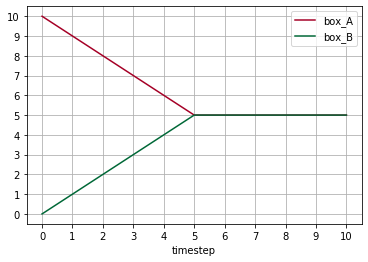

In [3]:
df.plot('timestep', ['box_A', 'box_B'], grid=True, 
        colormap = 'RdYlGn',
        xticks=list(df['timestep'].drop_duplicates()), 
        yticks=list(range(1+(df['box_A']+df['box_B']).max())));

# Policies
In part 1, we ignored the `_input` argument of state update functions. That argument is a signal passed to the state update function by another set of functions: Policy Functions.

Policy Functions are most commonly used as representations of the behavior of agents that interact with the components of the system we're simulating in cadCAD. But more generally, they describe the logic of some component or mechanism of the system. It is possible to encode the functionality of a policy function in the state update functions themselves (as we did in part 1, where we had the robot's algorithm reside in the `update_A` and `update_B` functions), but as systems grow more complex this approach makes the code harder to read and maintain, and in some cases more inefficient because of unnecessary repetition of computational steps.

The general structure of a policy function is:
```python
def policy_function(params, step, sL, s):
    ...
    return {'value1': value1, 'value2': value2, ...}
```
Just like State Update Functions, policies can read the current state of the system from argument `s`, a Python `dict` where the `dict_keys` are the __names of the variables__ and the `dict_values` are their __current values__. The Policy Function must return a dictionary, which will be passed as an argument (`_input`) to the state update functions.
![Policy](policy.png "Policy")

Let's update our simulation so that the robot arm's logic is encoded in a Policy instead of in the State Update Functions.

In [4]:
%%capture
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the robot arm's logic in a Policy Function
def robot_arm(params, step, sL, s):
    add_to_A = 0
    if (s['box_A'] > s['box_B']):
        add_to_A = -1
    elif (s['box_A'] < s['box_B']):
        add_to_A = 1
    return({'add_to_A': add_to_A, 'add_to_B': -add_to_A})
    

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)
def increment_A(params, step, sL, s, _input):
    y = 'box_A'
    x = s['box_A'] + _input['add_to_A']
    return (y, x)

def increment_B(params, step, sL, s, _input):
    y = 'box_B'
    x = s['box_B'] + _input['add_to_B']
    return (y, x)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm': robot_arm
        },
        'states': { # The following state variables will be updated simultaneously
            'box_A': increment_A,
            'box_B': increment_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

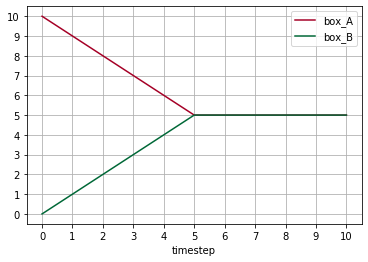

In [5]:
df.plot('timestep', ['box_A', 'box_B'], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        colormap = 'RdYlGn',
        yticks=list(range(1+(df['box_A']+df['box_B']).max())));

As expected, the results are the same as when the robot arm logic was encoded within the state update functions.  

Several policies may be evaluated within a Partial State Update Block. When that's the case, cadCAD's engine aggregates the outputs of the policies and passes them as a single signal to the state update functions. 
![Policies](policies.png "Policies")

Aggregation of policies is defined in cadCAD as __key-wise sum (+) of the elements of the outputted `dict`s__.
```python
>policy_1_output = {'int': 1, 'str': 'abc', 'list': [1, 2], '1-only': 'Specific to policy 1'}
>policy_2_output = {'int': 2, 'str': 'def', 'list': [3, 4], '2-only': 'Specific to policy 2'}
>print(aggregate([policy_1_output, policy_2_output]))
```
```
{'int': 3, 'str': 'abcdef', 'list': [1, 2, 3, 4], '1-only': 'Specific to policy 1', '2-only': 'Specific to policy 2'}
```

To illustrate, let's add to another system another robot arm identical to the first one, that acts in tandem with it. All it takes is to add a policy to the `dict` that describes the partial state update block.

In [6]:
%%capture
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm,
            'robot_arm_2': robot_arm
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': increment_A,
            'box_B': increment_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

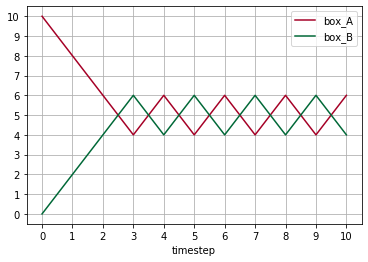

In [7]:
%matplotlib inline
df = pd.DataFrame(raw_result)
df.plot('timestep', ['box_A', 'box_B'], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        colormap = 'RdYlGn',
        yticks=list(range(1+(df['box_A']+df['box_B']).max())));

Because we have made it so that both robots read and update the state of the system at the same time, the equilibrium we had before (with 5 marbles in each box) is never reached. Instead, the system oscillates around that point.

---

_About BlockScience_  
[BlockScience](http://bit.ly/github_articles_M_02) is a research and engineering firm specialized in complex adaptive systems and applying practical methodologies from engineering design, development and testing to projects in emerging technologies such as blockchain. Follow us on [Medium](http://bit.ly/bsci-medium) or [Twitter](http://bit.ly/bsci-twitter) to stay in touch.